In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
np.random.seed(0)
plt.style.use("ggplot")

import tensorflow as tf

In [2]:
data=pd.read_csv("ner_dataset.csv",encoding="latin1")
data=data.fillna(method="ffill")
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O


In [3]:
print("Unique words : ", data["Word"].nunique())
print("Unique tags  : ", data["Tag"].nunique())

Unique words :  35178
Unique tags  :  17


In [4]:
words=list(set(data['Word'].values))
words.append("ENDPAD")
num_words=len(words)

In [5]:
tags=list(set(data["Tag"].values))
num_tags=len(tags)

In [6]:
num_words,num_tags

(35179, 17)

In [7]:
class RetrieveSentence(object):
    def __init__(self,data):
        self.n_sent=1
        self.data=data
        agg_fun=lambda s: [(w,p,t) for w,p,t in zip(s["Word"].values.tolist(),s['POS'].values.tolist(),s["Tag"].values.tolist())]
        self.grouped=self.data.groupby("Sentence #").apply(agg_fun)
        self.sentences=[s for s in self.grouped]

In [8]:
g=RetrieveSentence(data)
sentences=g.sentences

In [9]:
sentences[0]

[('Thousands', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('demonstrators', 'NNS', 'O'),
 ('have', 'VBP', 'O'),
 ('marched', 'VBN', 'O'),
 ('through', 'IN', 'O'),
 ('London', 'NNP', 'B-geo'),
 ('to', 'TO', 'O'),
 ('protest', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('war', 'NN', 'O'),
 ('in', 'IN', 'O'),
 ('Iraq', 'NNP', 'B-geo'),
 ('and', 'CC', 'O'),
 ('demand', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('withdrawal', 'NN', 'O'),
 ('of', 'IN', 'O'),
 ('British', 'JJ', 'B-gpe'),
 ('troops', 'NNS', 'O'),
 ('from', 'IN', 'O'),
 ('that', 'DT', 'O'),
 ('country', 'NN', 'O'),
 ('.', '.', 'O')]

In [10]:
word2idx={w:i+1 for i,w in enumerate(words)}
tag2idx={t:i for i,t in enumerate(tags)}

In [11]:
word2idx

{'sarcophagus': 1,
 'index': 2,
 'disowning': 3,
 'Millennium': 4,
 'Recalled': 5,
 'proudly': 6,
 'quarterfinals': 7,
 'disease': 8,
 'tainting': 9,
 'consolidation': 10,
 'donated': 11,
 '1887': 12,
 'Astronaut': 13,
 'sweeps': 14,
 '1994': 15,
 'nonrecurring': 16,
 'Kordofan': 17,
 'push': 18,
 'Alan': 19,
 'Cheikh': 20,
 'chill': 21,
 'Philippe': 22,
 'Peters': 23,
 'pressed': 24,
 'mainstays': 25,
 'rapes': 26,
 'Syarhei': 27,
 'Subsequent': 28,
 'Timessays': 29,
 'advised': 30,
 'School': 31,
 'orphanage': 32,
 'Echo': 33,
 'eavesdrop': 34,
 '1917': 35,
 'onerous': 36,
 'boarded': 37,
 'disavowed': 38,
 'forgery': 39,
 '1713': 40,
 'earmarks': 41,
 'Cong.': 42,
 'arose': 43,
 'orchestrate': 44,
 'Sato': 45,
 'hat': 46,
 'Maariv': 47,
 'Dizzy': 48,
 'IN': 49,
 '0-3': 50,
 'preventive': 51,
 'Chilitepic': 52,
 'relinquished': 53,
 'measured': 54,
 'gyroscopes': 55,
 'JAGDEO': 56,
 'haggling': 57,
 'dimming': 58,
 'ILO': 59,
 'overtake': 60,
 'spokesman': 61,
 'adamant': 62,
 'headl

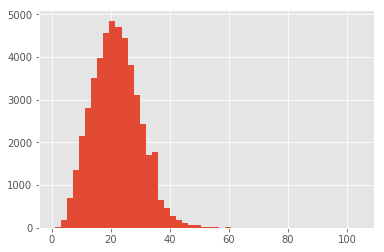

In [12]:
plt.hist([len(s) for s in sentences],bins=50)
plt.show()

In [13]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

max_len=50

X=[[word2idx[w[0]] for w in s] for s in sentences]
X=pad_sequences(maxlen=max_len,sequences=X,padding='post',value=num_words-1)

y=[[tag2idx[w[2]] for w in s] for s in sentences]
y=pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])
y=[to_categorical([i],num_classes=num_tags) for i in y]

In [14]:
y=np.array(y)

In [15]:
y.shape

(47959, 1, 50, 17)

In [16]:
y=y.reshape(47959,50,17)

In [17]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.1,random_state=1)

In [18]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

In [19]:
input_word=Input(shape=(max_len,))
model=Embedding(input_dim=num_words,output_dim=max_len,input_length=max_len)(input_word)
model=SpatialDropout1D(0.1)(model)
model=Bidirectional(LSTM(units=100,return_sequences=True,recurrent_dropout=0.1))(model)
out=TimeDistributed(Dense(num_tags,activation="softmax"))(model)
model=Model(input_word,out)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 50, 50)            1758950   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 50, 50)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 200)           120800    
_________________________________________________________________
time_distributed (TimeDistri (None, 50, 17)            3417      
Total params: 1,883,167
Trainable params: 1,883,167
Non-trainable params: 0
_________________________________________________________________


In [20]:
model.compile(optimizer='adam',loss="categorical_crossentropy",metrics=['accuracy'])

In [21]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback

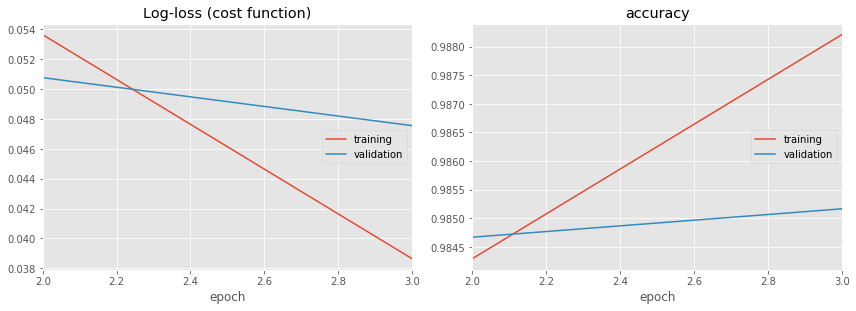

Log-loss (cost function):
training   (min:    0.039, max:    0.190, cur:    0.039)
validation (min:    0.048, max:    0.068, cur:    0.048)

accuracy:
training   (min:    0.957, max:    0.988, cur:    0.988)
validation (min:    0.981, max:    0.985, cur:    0.985)
34530/34530 [==============================] - 94s 3ms/sample - loss: 0.0386 - accuracy: 0.9882 - val_loss: 0.0476 - val_accuracy: 0.9852


In [22]:
early_stopping=EarlyStopping(monitor="val_accuracy",patience=1,verbose=0,mode="max")
callbacks=[PlotLossesCallback() , early_stopping]
history=model.fit(x_train,y_train,validation_split=0.2,batch_size=32,epochs=3,verbose=1,callbacks=callbacks)

### Task 8: Evaluate Named Entity Recognition Model

In [23]:
model.evaluate(x_test,y_test)

4796/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.049044726365203156, 0.98520017]

In [24]:
i=np.random.randint(0,x_test.shape[0])
p=model.predict(np.array([x_test[i]]))
p=np.argmax(p,axis=-1)
y_true=np.argmax(np.array(y_test),axis=-1)[i]
print("{:15}{:5}\t {}\n".format("word","true","pred"))
print("-"*30)
for w,true,pred in zip(x_test[i],y_true,p[0]):
    print("{:15}{}\t {}".format(words[w-1],tags[true],tags[pred]))

word           true 	 pred

------------------------------
The            O	 O
Sudanese       B-gpe	 B-gpe
government     O	 O
has            O	 O
welcomed       O	 O
the            O	 O
Chinese        B-gpe	 B-gpe
mission        O	 O
to             O	 O
Darfur         O	 B-geo
.              O	 O
onion          O	 O
onion          O	 O
onion          O	 O
onion          O	 O
onion          O	 O
onion          O	 O
onion          O	 O
onion          O	 O
onion          O	 O
onion          O	 O
onion          O	 O
onion          O	 O
onion          O	 O
onion          O	 O
onion          O	 O
onion          O	 O
onion          O	 O
onion          O	 O
onion          O	 O
onion          O	 O
onion          O	 O
onion          O	 O
onion          O	 O
onion          O	 O
onion          O	 O
onion          O	 O
onion          O	 O
onion          O	 O
onion          O	 O
onion          O	 O
onion          O	 O
onion          O	 O
onion          O	 O
onion          O	 O
onion          O	 O
o

In [25]:
i=np.random.randint(0,x_test.shape[0])
p=model.predict(np.array([x_test[i]]))
p=np.argmax(p,axis=-1)
y_true=np.argmax(np.array(y_test),axis=-1)[i]
print("{:15}{:5}\t {}\n".format("word","true","pred"))
print("-"*30)
for w,true,pred in zip(x_test[i],y_true,p[0]):
    print("{:15}{}\t {}".format(words[w-1],tags[true],tags[pred]))

word           true 	 pred

------------------------------
Model          O	 O
education      O	 O
,              O	 O
social         O	 O
,              O	 O
and            O	 O
environment    O	 O
programs       O	 O
are            O	 O
underway       O	 O
with           O	 O
support        O	 O
from           O	 O
multilateral   O	 O
development    O	 O
organizations  O	 O
.              O	 O
onion          O	 O
onion          O	 O
onion          O	 O
onion          O	 O
onion          O	 O
onion          O	 O
onion          O	 O
onion          O	 O
onion          O	 O
onion          O	 O
onion          O	 O
onion          O	 O
onion          O	 O
onion          O	 O
onion          O	 O
onion          O	 O
onion          O	 O
onion          O	 O
onion          O	 O
onion          O	 O
onion          O	 O
onion          O	 O
onion          O	 O
onion          O	 O
onion          O	 O
onion          O	 O
onion          O	 O
onion          O	 O
onion          O	 O
onion          O	 O
o